In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.models import Model, load_model

%matplotlib inline

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/TannerGilbert/Tutorials/master/Recommendation%20System/ratings.csv')

In [4]:
df.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [5]:
df.shape

(981756, 3)

In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
train.head()

,book_id,user_id,rating
341848,3423,4608,2
964349,9811,36373,5
645459,6485,2957,4
74960,750,42400,3
358670,3591,36886,5


In [9]:
n_users = df.user_id.nunique()
n_books = df.book_id.nunique()
print('Number of users:', n_users)
print('Number of books:', n_books)

Number of users: 53424
Number of books: 10000


## Dot product model

In [10]:
# creating book embedding path
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# performing dot product and creating model
prod = Dot(name="Dot-Product", axes=1)([book_vec, user_vec])
model = Model([user_input, book_input], prod)
model.compile('adam', 'mean_squared_error')

Train on 785404 samples
Epoch 1/5
785404/785404 [==============================] - 121s 154us/sample - loss: 13.0575
Epoch 2/5
785404/785404 [==============================] - 128s 163us/sample - loss: 3.7436
Epoch 3/5
785404/785404 [==============================] - 128s 162us/sample - loss: 1.6311
Epoch 4/5
785404/785404 [==============================] - 138s 176us/sample - loss: 1.1496
Epoch 5/5
785404/785404 [==============================] - 132s 168us/sample - loss: 0.9533


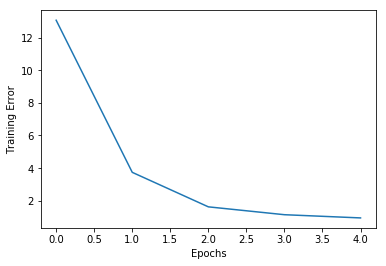

In [12]:
if os.path.exists('regression_model.h5'):
    model = load_model('regression_model.h5')
else:
    history = model.fit([train.user_id, train.book_id], train.rating, epochs=5, verbose=1)
    model.save('regression_model.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [13]:
model.evaluate([test.user_id, test.book_id], test.rating)

196352/196352 [==============================] - 6s 32us/sample - loss: 1.1253


1.125267094749146

In [14]:
predictions = model.predict([test.user_id.head(10), test.book_id.head(10)])

[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

[4.7618914] 5
[4.100345] 4
[3.153957] 3
[4.3588247] 5
[3.0665095] 3
[4.128582] 3
[4.206338] 3
[4.9127893] 4
[3.7402263] 3
[4.1481867] 5


[None, None, None, None, None, None, None, None, None, None]

## Neural network model

In [15]:
# creating book embedding path
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([book_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

# Create model and compile it
model2 = Model([user_input, book_input], out)
model2.compile('adam', 'mean_squared_error')
model2.summary()

Train on 785404 samples
Epoch 1/5
785404/785404 [==============================] - 129s 164us/sample - loss: 0.8032
Epoch 2/5
785404/785404 [==============================] - 138s 176us/sample - loss: 0.6889
Epoch 3/5
785404/785404 [==============================] - 137s 174us/sample - loss: 0.6620
Epoch 4/5
785404/785404 [==============================] - 138s 176us/sample - loss: 0.6367
Epoch 5/5
785404/785404 [==============================] - 137s 175us/sample - loss: 0.6147


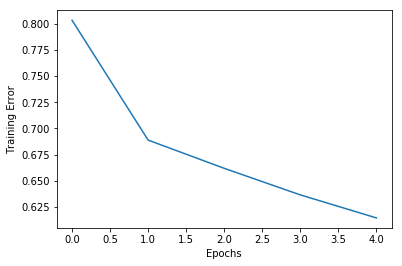

In [17]:
if os.path.exists('regression_model2.h5'):
    model2 = load_model('regression_model2.h5')
else:
    history = model2.fit([train.user_id, train.book_id], train.rating, batch_size=128, epochs=5)
    model2.save('regression_model2.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [23]:
model2.evaluate([test.user_id, test.book_id], test.rating, batch_size=1028)

196352/196352 [==============================] - 0s 2us/sample - loss: 0.7082


0.7081846794383079

In [24]:
predictions = model2.predict([test.user_id.head(10), test.book_id.head(10)])

[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

[4.98889] 5
[3.7504296] 4
[3.5085483] 3
[3.9569938] 5
[3.4591532] 3
[3.8977468] 3
[3.7141292] 3
[4.8090153] 4
[4.0702877] 3
[4.088274] 5


[None, None, None, None, None, None, None, None, None, None]

## Visualise embeddings

In [25]:
# Extract embeddings
book_em = model.get_layer('Book-Embedding')
book_em_weights = book_em.get_weights()[0]

In [26]:
book_em_weights[:5]

array([[-0.03906373, -0.0056355 , -0.04846726, -0.01491493,  0.01294214],
       [-1.5336652 ,  1.4493563 , -1.5986862 , -1.3674473 , -1.3837293 ],
       [-1.3721488 ,  1.3900319 , -1.4136233 , -1.2698017 , -1.1579    ],
       [-1.0283515 ,  1.2188652 , -1.0040958 , -1.007298  , -0.894124  ],
       [-1.4064388 ,  1.5754976 , -1.5092767 , -1.3635818 , -1.4801712 ]],
      dtype=float32)

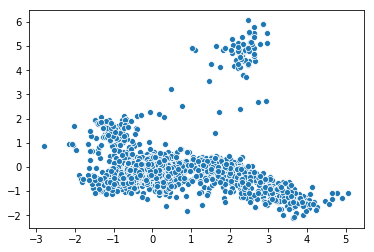

In [27]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [28]:
book_em_weights = book_em_weights / np.linalg.norm(book_em_weights, axis = 1).reshape((-1, 1))
book_em_weights[0][:10]
np.sum(np.square(book_em_weights[0]))

1.0000001

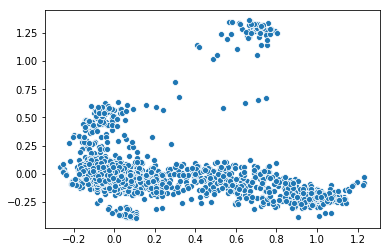

In [29]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [30]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(book_em_weights)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10001 samples in 0.005s...
[t-SNE] Computed neighbors for 10001 samples in 0.565s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10001
[t-SNE] Computed conditional probabilities for sample 2000 / 10001
[t-SNE] Computed conditional probabilities for sample 3000 / 10001
[t-SNE] Computed conditional probabilities for sample 4000 / 10001
[t-SNE] Computed conditional probabilities for sample 5000 / 10001
[t-SNE] Computed conditional probabilities for sample 6000 / 10001
[t-SNE] Computed conditional probabilities for sample 7000 / 10001
[t-SNE] Computed conditional probabilities for sample 8000 / 10001
[t-SNE] Computed conditional probabilities for sample 9000 / 10001
[t-SNE] Computed conditional probabilities for sample 10000 / 10001
[t-SNE] Computed conditional probabilities for sample 10001 / 10001
[t-SNE] Mean sigma: 0.015420
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.458527
[t-SNE] KL

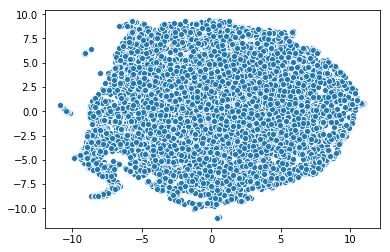

In [31]:
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

## Making recommendations

In [33]:
# Creating dataset for making recommendations for the first user
book_data = np.array(list(set(df.book_id)))
book_data[:5]

array([1, 2, 3, 4, 5])

In [34]:
user = np.array([1 for i in range(len(book_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [35]:
predictions = model.predict([user, book_data])

predictions = np.array([a[0] for a in predictions])

recommended_book_ids = (-predictions).argsort()[:5]

recommended_book_ids

array([7638, 8998, 8258, 9517, 7660], dtype=int64)

In [36]:
# print predicted scores
predictions[recommended_book_ids]

array([4.514963 , 4.41666  , 4.249961 , 4.208082 , 4.1993113],
      dtype=float32)

In [37]:
books = pd.read_csv('https://raw.githubusercontent.com/TannerGilbert/Tutorials/master/Recommendation%20System/books.csv')
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [38]:
books[books['id'].isin(recommended_book_ids)]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
7637,7638,12009,12009,2465248,28,1597800449,9.781598e+12,Iain M. Banks,2004.0,The Algebraist,...,13210,14793,606,185,684,3067,5984,4873,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
7659,7660,21330,21330,2910,15,1401204864,9.781401e+12,"Bill Willingham, Mark Buckingham, Steve Leialo...",2005.0,"Fables, Volume 5: The Mean Seasons",...,17909,18221,545,120,340,2889,7435,7437,https://images.gr-assets.com/books/1327870458m...,https://images.gr-assets.com/books/1327870458s...
8257,8258,18594594,18594594,26341000,41,345547497,9.780346e+12,Karin Slaughter,2014.0,Cop Town,...,10660,13997,1704,274,780,3299,5612,4032,https://images.gr-assets.com/books/1384822680m...,https://images.gr-assets.com/books/1384822680s...
8997,8998,292740,292740,2457130,37,2266071289,9.782266e+12,Lorenzo Carcaterra,1995.0,Sleepers,...,9560,10772,553,73,304,1775,4088,4532,https://images.gr-assets.com/books/1327871596m...,https://images.gr-assets.com/books/1327871596s...
9516,9517,17810,17810,856346,39,NaN,9.780143e+12,"Ryū Murakami, Ralph McCarthy",1997.0,イン ザ・ミソスープ,...,9285,11545,950,313,1107,3586,4346,2193,https://images.gr-assets.com/books/1309282509m...,https://images.gr-assets.com/books/1309282509s...
